In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
sys.path.append('..')
import pandas as pd
from model import VAE
import seaborn as sns
import input_pipeline

# Model

In [2]:
def sample(num_examples_to_generate, model):
    latent_dim = model.latent_dim
    random_mean = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
    log_var = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

    z = model.reparameterize(random_mean, log_var)
    predictions = model.sample(z)
    return predictions

def load_model_at_T(t, latent_dim = 200):
    model = VAE(latent_dim)
    dummy_input = tf.zeros((1, 32, 32, 1))
    model(dummy_input)
    model.load_weights(f'models/vae{t:.2}.h5')
    return model

## Models dictionary

In [3]:
temps = np.arange(2.0, 3.0, 0.1)
titles = [f"Temperature: {t:.2}" for t in temps]
models = {t: load_model_at_T(t) for t in temps}

# Example simulations

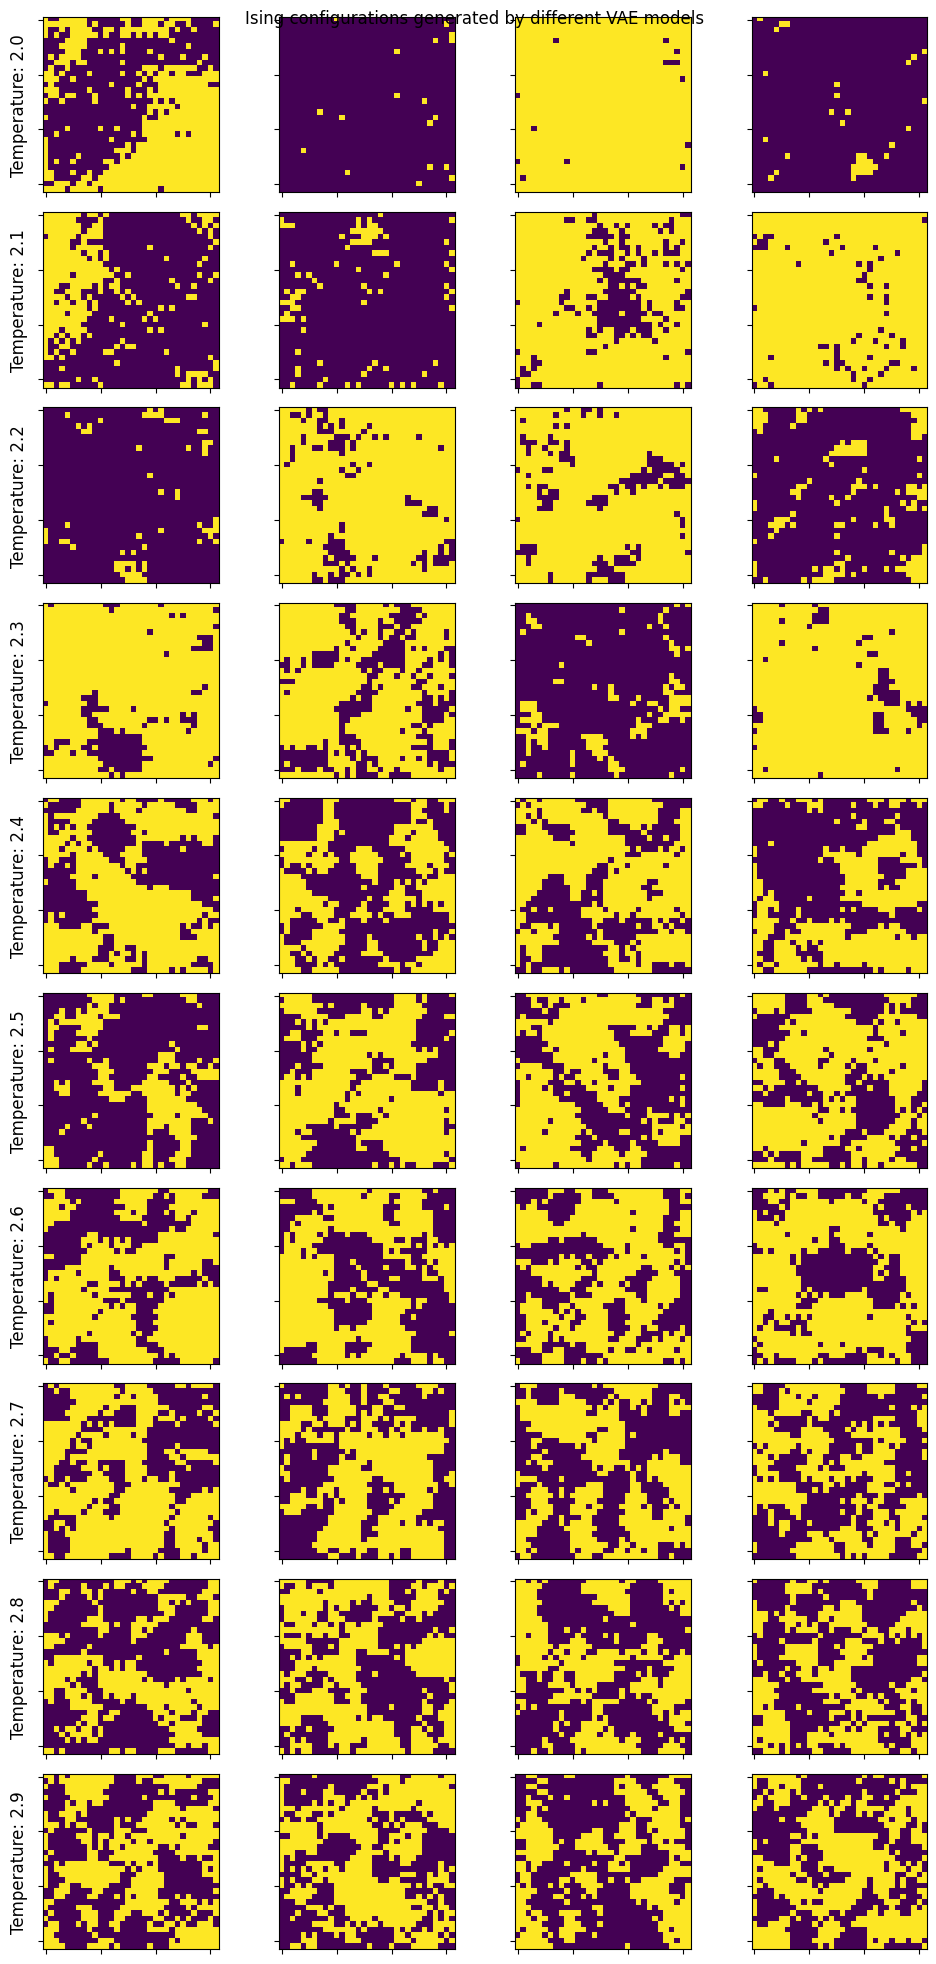

In [4]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(10, 20))
plt.suptitle("Ising configurations generated by different VAE models")
plt.subplots_adjust(top=0.96)
for i, ax_row in enumerate(axes):
    ax_row[0].set_ylabel(titles[i], rotation=90, size='large')
    predictions = sample(5, models[temps[i]])
    for j, ax in enumerate(ax_row):
        ax.yaxis.set_ticklabels([])
        ax.xaxis.set_ticklabels([])
        spins = np.random.binomial(1, predictions[j, :, :])
        ax.imshow(spins, vmin=0, vmax=1)

plt.tight_layout()

# Compare with monte carlo

In [5]:
num_examples_to_generate = 10000
latent_dim = 200

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

## Data

In [6]:
from results import get_df, get_stats

data_list = []
for temp in temps:
    # Monte Carlo
    trainset_path = f"../../GetData/Python/Data/Data{temp:.2}.tfrecord"
    batch_size = 10000
    train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
    data_mc = next(iter(train_set))
    data_mc = 2 * data_mc - 1
    df_monte_carlo = get_df(data_mc)
    mc_stats = get_stats(df_monte_carlo, temp)
    mc_stats.extend((temp, "Monte Carlo"))

    # Sampled from VAE
    model = models[temp]
    sample_data = []
    for _ in range(100):
        sample_data.append(sample(100, model))
    spin_sample = tf.concat(sample_data, axis = 0)
    spin_sample = 2 * np.random.binomial(1, spin_sample) - 1
    df_sampled = get_df(spin_sample)
    sample_stats = get_stats(df_sampled, temp)
    sample_stats.extend((temp, "Sampled VAE"))

    data_list.append(mc_stats)
    data_list.append(sample_stats)